# **Chap 4. 합성곱 신경망 (CNN)**

---



## **4. 위성 이미지 분류**

### **4.1 텐서플로 데이터셋 로드**

  - 데이터셋
    - 인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값이 정리되어 있는 EuroSAT 데이터
    - 총 27000장의 위성 사진과 10개의 토지이용분류 값이 매칭되어 제공


In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

  - EuroSAT 데이터셋을 `load 함수`를 이용해 불러온다. 
  - 데이터는 `(훈련 셋, 검증 셋), 메타 정보` 순으로 정릴되어 반환된다.
  - `URL을 통해 데이터를 다운로드`하고, `data_dir` 옵션에 파일 저장 위치를 지정하여 다운로드한 데이터셋 `파일을 해당 위치에 저장`한다.
  - 80%는 훈련 셋, 나머지 20% 데이터는 검증 셋으로 분할하여 저장한다.
  - 이미지는 (64, 64, 3) 형태이다.

In [2]:
# EuroSAT 위성 사진 데이터셋 로드
DATA_DIR = '/content/drive/MyDrive'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split = ['train[:80%]', 'train[80%:]'],
                                       shuffle_files = True,
                                       as_supervised = True,
                                       with_info = True,
                                       data_dir = DATA_DIR)

print(train_ds)
print(valid_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


  - 메타 정보를 할당받은 `info` 변수를 출력하면 `데이터셋에 대한 기본 정보`를 확인할 수 있다.
  - 현재 EuroSAT 데이터셋의 2가지 유형 중, `JPEG 이미지로 인코딩한 RGB 데이터셋`을 다운로드한 상태이다.

In [10]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='/content/drive/MyDrive/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    sup

  - `show_examples()` 함수를 활용해 `샘플 이미지`를 메타 정보인 `분류 레이블과 함께 화면에 출력`한다.

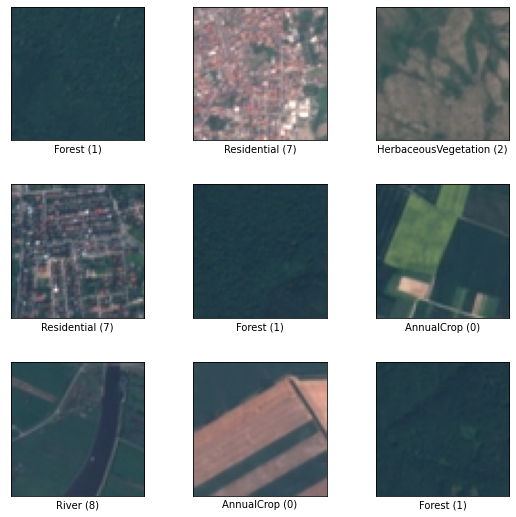

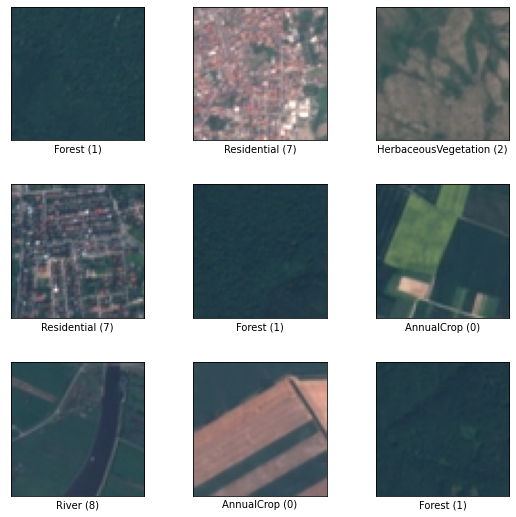

In [ ]:
# 데이터 확인
tfds.show_examples(train_ds, info)

  - `as_dataframe` 함수를 활용해 샘플 이미지 10개를 화면에 표시해보자.

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

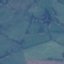
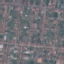
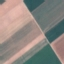
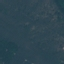
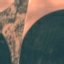
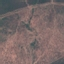
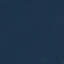
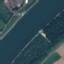
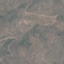
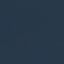

In [ ]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

  - 토지이용분류에 해당하는 정답 클래스 개수는 10개이다.

In [11]:
# 목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


  - 클래스를 나타내는 `숫자 레이블`을 `메타 데이터의 문자열로 변환`할 수 있다.
  - 메타 데이터의 feature 값 중에서 `label에 해당하는 메타 정보`에 `int2str()` 메소드를 적용한다.
  - 아래와 같이 클래스 6은 영구작물을 나타내는 것을 확인할 수 있다.

In [12]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


### **4.2 데이터 전처리**

  - 데이터 전처리 과정 
    - 텐서플로 연산은 float32 숫자 값을 사용하므로, `cast` 함수를 사용해 `자료형을 float32로 변환`한다.
    - `입력 이미지`는 0~255 범위의 픽셀 값을 가지므로, 255로 나누어 `정규화`한다.
    - map 함수를 활용해 사용자 정의 함수를 매핑하고, `num_parallel_calls` 옵션을 `오토튠으로 지정`해 텐서플로 `병렬연산 처리`를 자동으로 최적화한다.
    - 정규화 변환을 마친 데이터셋에 `shuffle()` 메소드를 적용해 순서를 랜덤하게 섞어 준다.
      - `모델의 일반화된 성능을 높이기 위해` 훈련 데이터셋에서 미니 배치를 생성할 때 입력 `순서에 무작위성을 부여`하는 개념이다.
      - BUFFER_SIZE를 1000으로 지정하고 BATCH_SIZE를 64로 지정하면, 처음 1000개의 데이터를 가져와서 섞고 여기서 64개의 데이터를 랜덤하게 선택해 하나의 배치를 구성한다.
    - `prefetch()` 메소드는 모델이 훈련을 진행하는 동안 `다음에 입력할 데이터를 불러와서 미리 전처리`를 하도록 시스템을 조율한다.

In [16]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255. #0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### **4.3 모델 훈련 및 검증**

  - 배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛을 2개 연결하고, Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 Sequential API로 생성한다.

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

  model = tf.keras.Sequential([
      
      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax'),
  ])

  return model

model = build_model()

  - `예측 클래스가 10개`인 `다중 분류` 문제에 맞게 `손실함수`와 `평가지표`를 설정하고, 모델을 `50 epoch 훈련`시킨다.

In [ ]:
# 모델 컴파일
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# 모델 훈련
history = model.fit(train_data, validation_data = valid_data, epochs = 50)

Epoch 1/50
338/338 [==============================] - 211s 619ms/step - loss: 1.6988 - accuracy: 0.3989 - val_loss: 1.5592 - val_accuracy: 0.4476
Epoch 2/50
338/338 [==============================] - 185s 547ms/step - loss: 1.3109 - accuracy: 0.5319 - val_loss: 0.9385 - val_accuracy: 0.6796
Epoch 3/50
338/338 [==============================] - 182s 539ms/step - loss: 1.0895 - accuracy: 0.6161 - val_loss: 0.8762 - val_accuracy: 0.7122
Epoch 4/50
338/338 [==============================] - 220s 650ms/step - loss: 0.9637 - accuracy: 0.6616 - val_loss: 0.7102 - val_accuracy: 0.7541
Epoch 5/50
338/338 [==============================] - 239s 707ms/step - loss: 0.8705 - accuracy: 0.6981 - val_loss: 0.7414 - val_accuracy: 0.7267
Epoch 6/50
338/338 [==============================] - 219s 647ms/step - loss: 0.7812 - accuracy: 0.7287 - val_loss: 0.6849 - val_accuracy: 0.7791
Epoch 7/50
338/338 [==============================] - 239s 706ms/step - loss: 0.7317 - accuracy: 0.7492 - val_loss: 0.6121 -

  - 모델은 `10 epoch`까지는 빠른 속도로 훈련이 진행되면서 `손실함수가 급격하게 감소`한다.
  - 하지만 `그 이후로는` 검증셋에 대한 손실함수가 더 이상 줄어들지 않으면서 `과대적합` 경향을 보인다.

In [11]:
# 모델의 예측 오차와 정확도를 그래프로 그리는 함수
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].plot(range(1, epoch+1), loss, label='Training')
    axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch+1), acc, label='Training')
    axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

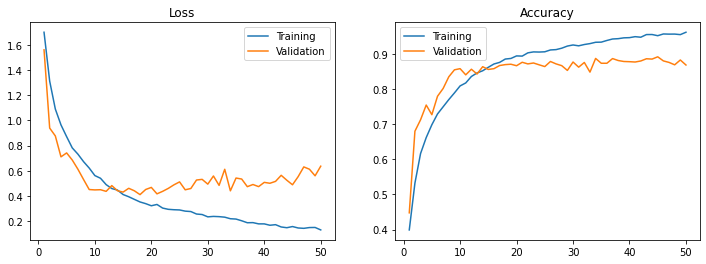

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 50)

### **4.4 데이터 증강**

  - 과대적합을 해소하는 기법인 배치 정규화, Dropout 등을 적용했음에도 과대적합이 발생하였다.
  - `이미지 분류` 문제에서 `과대적합을 해소`하고, 모델의 `일반화된 Robust한 성능을 확보`하는 기법으로 `데이터 증강` 기법을 사용한다.
  - `데이터 증강`
    - 이미지 `데이터에 여러 가지 변형`을 주어서 훈련 `데이터의 다양성을 확보`하는 방식으로, 모델이 `새로운 데이터에 대한 예측력을 강화`하도록 하는 개념이다.

  - 먼저 EuroSAT 데이터셋 중에서 `하나의 샘플 이미지`를 선택하여 `시각화`한다.

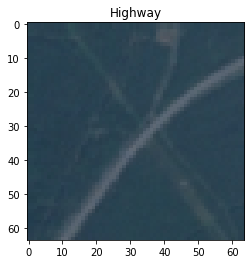

In [ ]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label));

  - 샘플 이미지에 변화를 주기 전과 후의 이미지를 비교할 수 있는 시각화 함수를 정의한다.

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

  fig, axes = plt.subplots(1, 2, figsize = (12, 4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

  - tf.image 모듈의 `flip_left_right` 함수를 사용하여 `이미지를 좌우 방향으로 뒤집는 방법`이다.

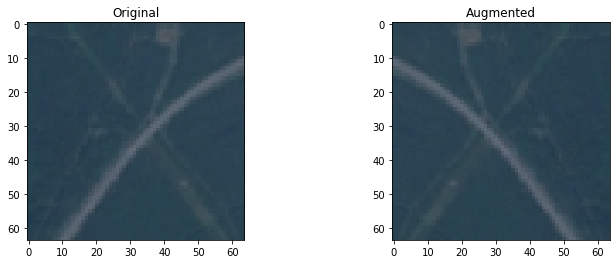

In [ ]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

  - `flip_up_down` 함수를 사용해 `이미지를 상하 방향으로 뒤집는다.`

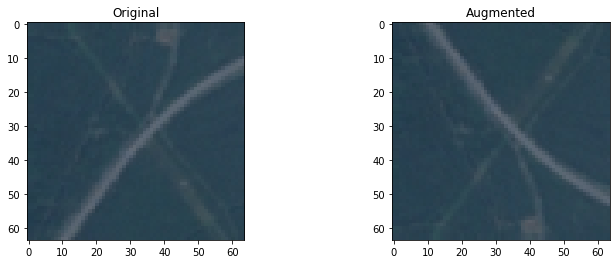

In [ ]:
# 상하 뒤집기
up_flip = tf.image.flip_up_down(image)
plot_augmentation(image, up_flip)

  - `rot90` 함수를 사용하면 이미지를 `반시계 방향으로 90도 회전`시킨다.

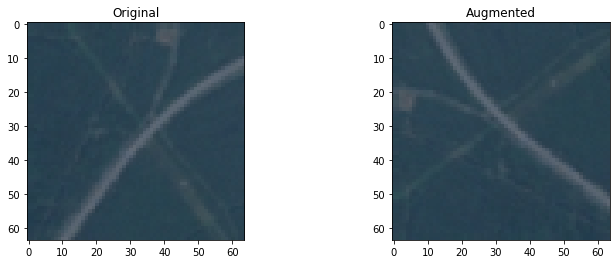

In [ ]:
# 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

  - `transpose` 함수는 이미지 텐서 행렬의 행과 열의 위치를 바꿔 준다(`행렬의 도치`).

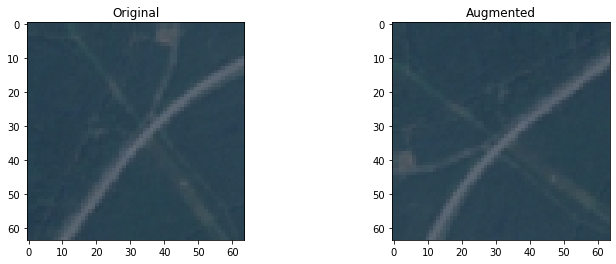

In [ ]:
# transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

  - `central_crop` 함수는 이미지의 `중심에서 일정 부분을 잘라내는 방법`을 구현한다.

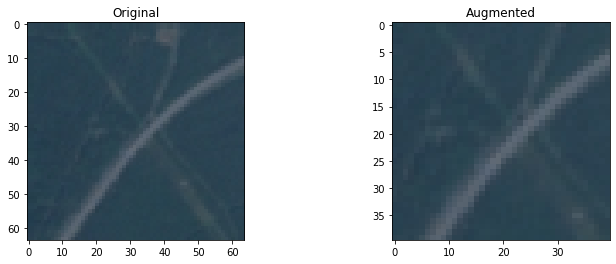

In [ ]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction = 0.6)
plot_augmentation(image, crop1)

  - `resize_with_crop_or_pad` 함수를 사용하여 원본 `이미지의 크기를 키운다`.
  - 여기에 `random_crop` 함수를 사용하고 이미지를 `원본 크기와 같게 자르면`, `원본 이미지가 상하좌우 랜덤한 방향`으로 시프트 이동한다.

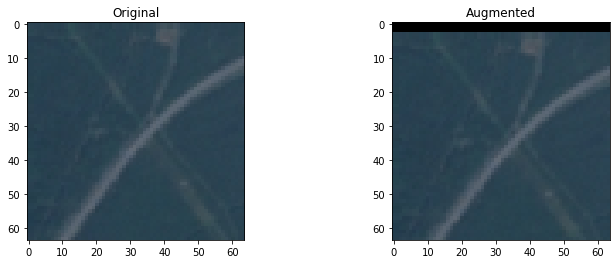

In [ ]:
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20)   # 사이즈 키우기
crop2 = tf.image.random_crop(img, size = [64, 64, 3])
plot_augmentation(image, crop2)

  - 이미지의 `밝기를 직접 조정`할 수도 있다.

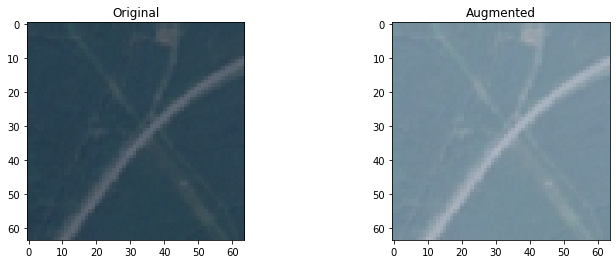

In [ ]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta = 0.3)
plot_augmentation(image, brightness)

  - 이미지의 `채도를 변경`하는 방법도 있다.

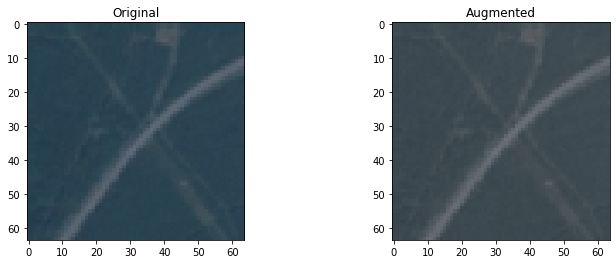

In [ ]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor = 0.5)
plot_augmentation(image, saturation)

  - 이미지의 `대비를 조정`할 수도 있다.

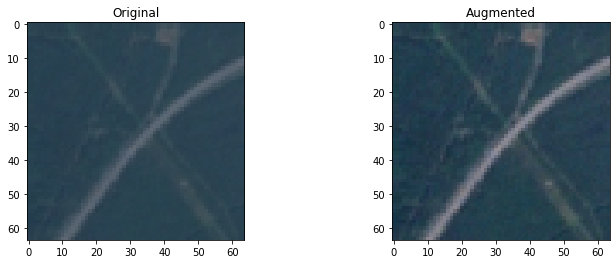

In [ ]:
# 이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor = 2)
plot_augmentation(image, contrast)

  - 앞서 다룬 여러 기법 중에서 몇 가지를 선택하여 데이터 증강 및 전처리를 수행하는 data_augmentation 사용자 함수를 정의한다.
  - 이미지 `증강 효과에 랜덤성을 부여`하기 위해 `tf.image 모듈`에서 지원하는 함수 중에서 '`random_`'으로 시작하는 함수를 적용한다.
  - map 함수로 원본 데이터셋에 적용하고, shuffle 함수와 batch 함수 등을 적용하여 미니 배치로 만들어 준다.

In [17]:
# 이미지 증강 전처리
def data_augmentation(image, label):

  image = tf.image.random_flip_left_right(image)    # 좌우 반전
  image = tf.image.random_flip_up_down(image)   # 상하 반전
  image = tf.image.random_brightness(image, max_delta = 0.3)    # 밝기 변화
  image = tf.image.random_crop(image, size = [64, 64, 3])

  image = tf.cast(image, tf.float32) / 255    # 0~1 정규화

  return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


  - 모델 인스턴스를 생성하고, 컴파일을 거쳐 `50 epoch 동안 훈련`시킨다.
  - 데이터 증강을 하기 전과 모델의 성능 자체는 큰 차이가 없다.

In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, validation_data = valid_aug, epochs = 50)

Epoch 1/50
338/338 [==============================] - 193s 566ms/step - loss: 1.9627 - accuracy: 0.2616 - val_loss: 1.8841 - val_accuracy: 0.3322
Epoch 2/50
338/338 [==============================] - 188s 556ms/step - loss: 1.6737 - accuracy: 0.3342 - val_loss: 1.3909 - val_accuracy: 0.4420
Epoch 3/50
338/338 [==============================] - 187s 553ms/step - loss: 1.5462 - accuracy: 0.3861 - val_loss: 1.2842 - val_accuracy: 0.5215
Epoch 4/50
338/338 [==============================] - 185s 548ms/step - loss: 1.4891 - accuracy: 0.4138 - val_loss: 1.2944 - val_accuracy: 0.5020
Epoch 5/50
338/338 [==============================] - 187s 552ms/step - loss: 1.4361 - accuracy: 0.4420 - val_loss: 1.2109 - val_accuracy: 0.5633
Epoch 6/50
338/338 [==============================] - 184s 545ms/step - loss: 1.3880 - accuracy: 0.4689 - val_loss: 1.1857 - val_accuracy: 0.5702
Epoch 7/50
338/338 [==============================] - 183s 541ms/step - loss: 1.3635 - accuracy: 0.4819 - val_loss: 1.1753 -

  - 손실함수와 정확도를 그래프로 그려보면, 훈련 셋과 검증 셋에 대한 `손실함수는 50 epoch 동안 계속 줄어들고` `정확도는 조금씩 우상향하면서 개선`되고 있다.
  - 즉, `과대적합 문제가 상당히 해소`된 것을 알 수 있다.

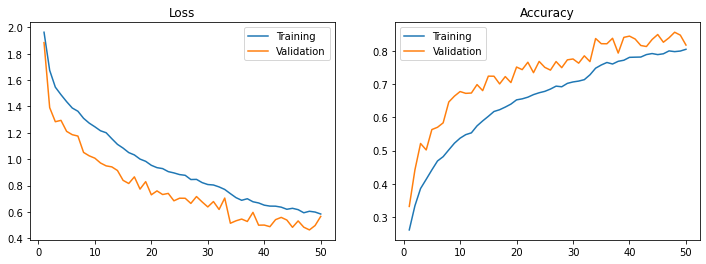

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 50)

### **4.5 ResNet 사전 학습 모델**

  - ResNet 모델을 활용해 위성 이미지를 분류한다.
    - `사전에` 방대한 이미지로 `훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로` 가져오고, 모델의 끝단에 위치하는 `Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가`하는 방식으로 모델을 구성한다.
    - 이런 방식으로 딥러닝 모델을 구성하는 것을 `전이 학습(Transfer Learning)`이라고 부른다.

  - `input_shape` 속성에 위성 이미지의 크기인 `(64, 64, 3)을 지정`한다.
  - 원래 ResNet 모델의 입력 크기는 (224, 224, 3)이므로, 케라스에서 `이미지 크기를 우리가 지정한 크기로 맞춰서 줄인다`.
  - 그리고 분류하려는 `클래스 레이블의 개수`(10)를 `classes 속성에 지정`한다.
  - 가장 중요한 옵션은 `include_top = False`로 지정하는 것이다.
    - 기존 ResNet 모델의 Top 층은 이미지넷 경진 대회에 맞는 분류기이므로, `False로 지정`하여 `Top 층을 제거`해 준다.
    - `제거된 부분에` 우리가 해결하려는 문제에 맞는 `최종 분류기를 대체해서 추가`하게 된다.

In [3]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                              weights='imagenet',
                              input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

Output hidden; open in https://colab.research.google.com to view.

  - 최종적으로 `10개 클래스에 대한 다중 분류`를 할 수 있도록 `Dense 레이어의 노드 개수`와 `softmax 활성화 함수`를 지정한다.

In [13]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():
  
  model = tf.keras.Sequential([
      
      # Pre-trained Base
      pre_trained_base,

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
  ])

  return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                6

  - 모델을 컴파일하고 50 epoch 동안 훈련시킨다.

In [18]:
# 모델 컴파일
tc_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

# 모델 훈련
tc_history = tc_model.fit(train_aug, validation_data = valid_aug, epochs = 50)

Epoch 1/50
338/338 [==============================] - 353s 1s/step - loss: 1.0597 - accuracy: 0.6646 - val_loss: 0.6301 - val_accuracy: 0.7967
Epoch 2/50
338/338 [==============================] - 332s 982ms/step - loss: 0.7337 - accuracy: 0.7684 - val_loss: 0.5393 - val_accuracy: 0.8217
Epoch 3/50
338/338 [==============================] - 333s 984ms/step - loss: 0.6518 - accuracy: 0.7953 - val_loss: 0.4963 - val_accuracy: 0.8363
Epoch 4/50
338/338 [==============================] - 333s 986ms/step - loss: 0.6104 - accuracy: 0.8030 - val_loss: 0.5057 - val_accuracy: 0.8365
Epoch 5/50
338/338 [==============================] - 332s 982ms/step - loss: 0.5756 - accuracy: 0.8164 - val_loss: 0.4728 - val_accuracy: 0.8413
Epoch 6/50
338/338 [==============================] - 334s 987ms/step - loss: 0.5395 - accuracy: 0.8234 - val_loss: 0.4542 - val_accuracy: 0.8509
Epoch 7/50
338/338 [==============================] - 336s 993ms/step - loss: 0.5283 - accuracy: 0.8298 - val_loss: 0.4436 - va

  - 그래프를 보면 훈련 초기부터 검증 셋에 대한 정확도가 80%를 넘어선다.
  - 즉, 사전 학습 모델인 ResNet 모델의 가중치를 그대로 사용하기 때문에 새로운 데이터인 위성 이미지와 입력되어도 이미지로부터 피처를 빠르게 추출하는 것으로 볼 수 있다.

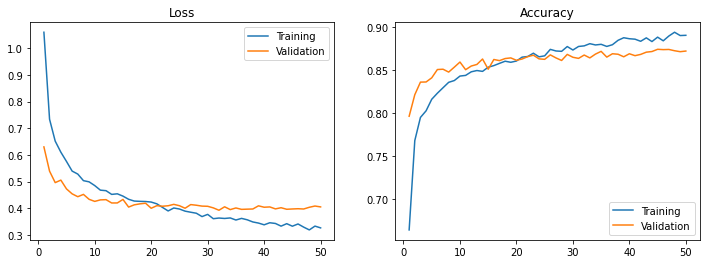

In [21]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(tc_history, 50)

---

## **5. 개/고양이 분류**

  - 실무에서 다루는 이미지 파일은 용량이 크거나 파일 개수가 많아서 메모리 또는 그래픽 카드 `메모리가 부족한 상황`이 발생한다.
  - 이런 문제를 해결하려면 `이미지 데이터셋을` 32장, 64장, 128장 등 `배치 단위로 나눈 다음`, `배치 한 개를 읽어와 딥러닝 모델에 주입`하면 메모리 부담 없이 학습할 수 있다.
  - 전체 데이터셋을 `전부 모델에 입력할 때까지` 배치 단위로 읽어오고 주입하는 과정을 `반복`한다.

  - 이번에는 `데이터셋을 배치 단위의 여러 부분으로 나누고` 반복 객체를 통해서 `각 배치를 한 개씩 모델에 입력하여 훈련`하는 방법을 소개한다.
  - 이 과정을 손쉽게 처리할 수 있도록 텐서플로 케라스는 `ImageDataGenerator 함수`를 지원한다.

### **5.1 분석 준비**

#### 5.1.1 데이터셋 다운로드

  - 캐글에 공개된 'Cat and Dog' 데이터셋을 로컬 PC에 다운로드받아서 구글 드라이브에 업로드한 뒤, 구글 코랩을 실행하여 구글 드라이브에 마운트해 직접 읽어오는 방법을 사용한다.

#### 5.1.2 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

#### 5.1.3 구글 드라이브 마운트

In [2]:
# 설정 완료

#### 5.1.4 압축 파일 해제

  - 구글 드라이브에 저장되어 있는 파일 경로를 source_filename 변수에 지정하고 압축을 해제한 파일을 저장할 경로를 정한다.
  - `shutil` 라이브러리를 활용해 `압축 파일을 해제`한다.

In [3]:
# 압축 파일의 위치
drive_path = '/content/drive/MyDrive/'
source_filename = drive_path + 'dataset/cat-and-dog.zip'

# 저장할 경로
extract_folder = 'dataset/'   # 코랩 환경에 임시 저장

# 압축 해제
import shutil
shutil.unpack_archive(source_filename, extract_folder)

In [4]:
# 훈련 셋, 검증 셋 저장 위치 지정
train_dir = extract_folder + 'training_set/training_set'
valid_dir = extract_folder + 'test_set/test_set'

print(train_dir)
print(valid_dir)

dataset/training_set/training_set
dataset/test_set/test_set


### **5.2 모델 학습**

#### 5.2.1 ImageDataGenerator

  - 케라스 `ImageDataGenerator` 클래스 함수를 실행하고, `rescale` 옵션을 지정해 이미지 각 픽셀의 값을 `0~1 범위로 정규화`한다.
  - 생성된 제너레이터 객체를 image_gen 변수에 할당한다.

In [5]:
# 이미지 데이터 제너레이터 정의(Augmentation 미적용)
image_gen = ImageDataGenerator(rescale = (1/255.))
image_gen

#### 5.2.2 flow_from_directory 함수

  - 이미지 제너레이터 객체에 `flow_from_directory` 함수를 적용하면, 지정한 폴더에서 `이미지를 가져와 반복 이터레이션`이 가능하도록 데이터셋을 처리한다.
  - 훈련 셋이 저장되어 있는 train_dir, `batch_size` 속성에는 배치를 구성하는 `이미지 개수(batch_size) 32`, `target_size` 속성에는 저장될 이미지의 `(세로, 가로) 픽셀 사이즈`, `classes` 속성에는 `클래스 레이블`, `class_mode`에는 이진 분류 문제를 나타내는 '`binary`' 모드, 랜덤 시드 값을 지정한다.

In [6]:
# flow_from_directory 함수로 폴더에서 이미지를 가져와 제너레이터 객체로 정리
train_gen = image_gen.flow_from_directory(train_dir,
                                          batch_size = 32,
                                          target_size = (224, 224),
                                          classes = ['cats', 'dogs'],
                                          class_mode = 'binary',
                                          seed = 2020)

valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size = 32,
                                          target_size = (224, 224),
                                          classes = ['cats', 'dogs'],
                                          class_mode = 'binary',
                                          seed = 2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


  - 1개의 배치를 선택해서 배치 안에 들어 있는 32개의 이미지를 정답 클래스 레이블과 함께 출력하면 다음과 같다.

<ipython-input-7-b78fc2744073>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


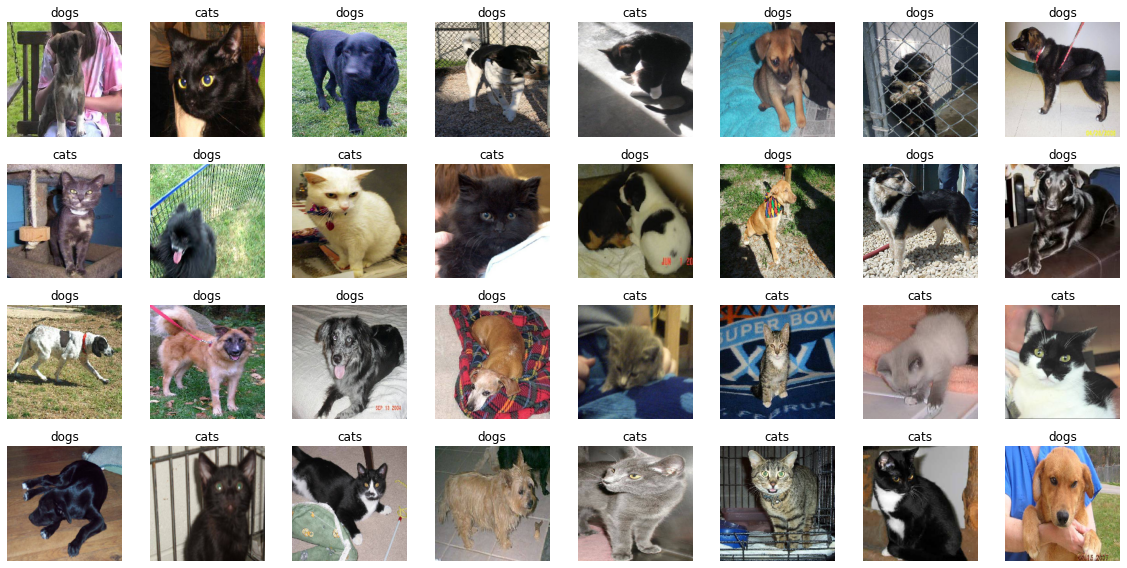

In [7]:
# 샘플 이미지 출력
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize = (16, 8))
for i in range(32):

  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(images[i])
  plt.title(class_labels[labels[i].astype(np.int)])
  plt.axis('off')

plt.tight_layout()
plt.show()

#### 5.2.3 모델 훈련

  - `이진 분류 모델`을 정의한다.
  - '`배치 정규화 - 합성곱 - 풀링`'으로 구성된 단위블럭을 `3개 반복`하여 이미지로부터 `다양한 피처를 추출`하고, `최종 분류기`로는 `Dense` 레이어를 사용한다. `최종 출력 레이어`는 `노드 1개`를 갖고, `활성화 함수`로는 '`sigmoid`'를 적용한다.

In [8]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

  model = tf.keras.Sequential([
      
      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),      

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation = 'sigmoid'),
  ])

  return model

model = build_model()

  - 옵티마이저, 손실함수를 지정한다.
  - 모델을 컴파일하고, 20 epoch 동안 훈련시킨다.

In [9]:
# 모델 컴파일
model.compile(optimizer = tf.optimizers.Adam(lr = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data = valid_gen, epochs = 20)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 41s 153ms/step - loss: 2.2929 - accuracy: 0.5550 - val_loss: 0.6502 - val_accuracy: 0.6322
Epoch 2/20
251/251 [==============================] - 36s 142ms/step - loss: 0.6333 - accuracy: 0.6316 - val_loss: 0.6226 - val_accuracy: 0.6233
Epoch 3/20
251/251 [==============================] - 36s 142ms/step - loss: 0.6116 - accuracy: 0.6546 - val_loss: 0.5972 - val_accuracy: 0.6584
Epoch 4/20
251/251 [==============================] - 36s 143ms/step - loss: 0.5880 - accuracy: 0.6748 - val_loss: 0.5850 - val_accuracy: 0.6629
Epoch 5/20
251/251 [==============================] - 36s 141ms/step - loss: 0.5813 - accuracy: 0.6926 - val_loss: 0.5707 - val_accuracy: 0.6970
Epoch 6/20
251/251 [==============================] - 36s 145ms/step - loss: 0.5534 - accuracy: 0.7009 - val_loss: 0.5671 - val_accuracy: 0.7103
Epoch 7/20
251/251 [==============================] - 35s 140ms/step - loss: 0.5514 - accuracy: 0.6993 - val_loss: 0.5412 - val_accuracy: 0.7

  - 훈련셋에 대한 정확도는 92%, 검증셋에 대한 정확도는 79% 정도로 과대적합이 발생하였다.
  - 다음과 같이 손실함수 그래프를 그려보면 과대적합이 빠르게 발생한 것을 알 수 있다.

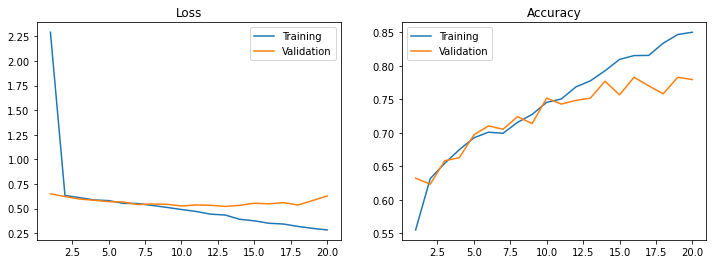

In [12]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 20)

#### 5.2.4 데이터 증강

  - ImageDataGenerator를 사용하면 다양한 데이터 증강 기법을 클래스 함수의 매개변수 속성으로 지정할 수 있어 편리하다.
  - 다음 코드에서는 좌우 방향으로 뒤집는 horizontal_flip 속성을 지정하고, 회전은 최대 30도로 지정한다. 이미지를 반시계 방향으로 밀리도록 변형시키는 shear_range 속성과 이미지를 줌으로 확대하는 zoom_range 속성을 추가한다.
  - 이미지 파일이 저장되어 있는 폴더에서 이미지를 배치 단위로 불러와 데이터 증강 기법을 적용하고, 목표 크기에 맞춰서 미니 배치를 구성한다. 이것들을 모아서 반복 이터레이션 객체를 만든다.


In [13]:
# 이미지 데이터 제너레이션 정의(Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale = 1/255.,
                                   horizontal_flip = True,
                                   rotation_range = 30,
                                   shear_range = 0.15,
                                   zoom_range = 0.3)

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size = 32,
                                                  target_size = (224, 224),
                                                  classes = ['cats', 'dogs'],
                                                  class_mode = 'binary',
                                                  seed = 2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size = 32,
                                                  target_size = (224, 224),
                                                  classes = ['cats', 'dogs'],
                                                  class_mode = 'binary',
                                                  seed = 2020)

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer = tf.optimizers.Adam(lr = 0.001),
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data = valid_gen_aug, epochs = 20)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/20
251/251 [==============================] - 126s 499ms/step - loss: 1.7933 - accuracy: 0.5385 - val_loss: 0.6780 - val_accuracy: 0.6179
Epoch 2/20
251/251 [==============================] - 124s 496ms/step - loss: 0.6693 - accuracy: 0.5698 - val_loss: 0.6486 - val_accuracy: 0.5937
Epoch 3/20
251/251 [==============================] - 124s 494ms/step - loss: 0.6475 - accuracy: 0.6062 - val_loss: 0.6149 - val_accuracy: 0.6416
Epoch 4/20
251/251 [==============================] - 124s 495ms/step - loss: 0.6463 - accuracy: 0.6079 - val_loss: 0.6244 - val_accuracy: 0.5902
Epoch 5/20
251/251 [==============================] - 123s 491ms/step - loss: 0.6423 - accuracy: 0.6104 - val_loss: 0.6241 - val_accuracy: 0.6337
Epoch 6/20
251/251 [==============================] - 125s 496ms/step - loss: 0.6383 - accuracy: 0.6125 - val_loss: 0.6161 - val_accuracy: 0.6278
Epoch 7/20
251/251 [====================

  - 손실함수와 모델의 정확도를 그래프로 그려보면, 과대적합이나 과소적합이 거의 발생하지 않고 학습이 잘 진행되는 것을 확인할 수 있다.

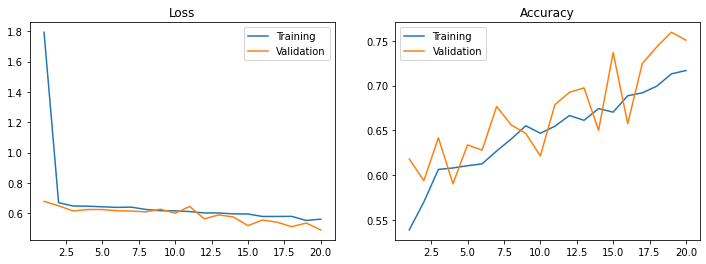

In [14]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history_aug, 20)